# Credit Card Approval Using Machine Learning
WWI20DSA; Semester-4;  <br>
Chengyi Hua (8883221); Yassir Knierim (57590); Jan Rüdt ()

## Project description
Credit scoring is a widely used risk management technique in the financial sector. It makes use of personal information and data provided by credit card applicants to estimate future bankruptcies and credit card loans. The bank has the authority to determine whether or not to provide the applicant a credit card. Credit scores can estimate the level of risk objectively. A machine learning model is required to predict if an application is a 'good' or 'bad' user in this dataset. By our target variable or definition it should predict if the User is categorised as risk user or not. 
<br>
<br>
 
Impediments: <br>
the unbalanced data problem is a significant issue in this project.<br>
Possible solution: using the pycaret package to fix the unbalanced dataset

## What is Pycaret and why to use Pycaret

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.
<br>
<br>
Compared with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with few lines only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and a few more.
<br>
<br>
As more businesses shifted their focus to Machine Learning to address challenging issues, data scientists were expected to give results faster. This has increased the demand for automating important phases in data science projects so that data scientists may focus on the real problem at hand rather than writing hundreds of lines of code to identify the optimal model.

## Loading dependencies

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import pycaret
import math

import pycaret.classification 

# --- Libraries Settings ---
#warnings.filterwarnings('ignore')
#plt.rcParams['figure.dpi'] = 100

## Adjusting dataset

In [3]:
cca =  pd.read_csv('credit_card_approval.csv')
# rough years of employment
cca.DAYS_EMPLOYED = abs(cca.DAYS_EMPLOYED) // 365
# finding out each customers age
cca.DAYS_BIRTH =  abs(cca.DAYS_BIRTH) // 365  
cca.AMT_INCOME_TOTAL = pd.to_numeric(cca.AMT_INCOME_TOTAL)
# dropping unneccessary attributes
cca = cca.drop(["BEGIN_MONTHS", "FLAG_MOBIL"], axis=1)



cca.rename(columns = {'CODE_GENDER':'gender', 
                      'DAYS_BIRTH': 'age',
                      'DAYS_EMPLOYED': 'working_years',
                      'FLAG_OWN_CAR':'owning_car',
                      'FLAG_OWN_REALTY': 'owning_property',
                      'CNT_CHILDREN': 'children_amt',
                      'AMT_INCOME_TOTAL': 'anual_income',
                      'NAME_EDUCATION_TYPE': 'education_level',
                      'NAME_FAMILY_STATUS': 'marital_status',
                      'NAME_HOUSING_TYPE': 'way_of_living',
                      'FLAG_WORK_PHONE': 'owning_work_phone',
                      'FLAG_EMAIL': 'owning_email',
                      'FLAG_PHONE': 'owning_phone',
                      'STATUS': 'payment_status',
                      'TARGET': 'risk_user',
                      'JOB': 'job',
                      'ID': 'applicant_ID'
                      }, inplace = True)


cca["owning_car"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["risk_user"].replace({1: 'Y', 0: 'N' }, inplace= True)
cca["owning_property"].replace({'Y' : '1', 'N': '0'}, inplace= True)
cca["payment_status"].replace({'0' : '0-29 d overdue', 
                               '1': '30-29 d overdue', 
                               '2': '60-89 d overdue', 
                               '3': '90-119 d overdue', 
                               '4': '120-149 d overdue', 
                               '5': 'bad debts', 
                               'C': 'paid', 
                               'X': 'no loan'}, inplace= True)
cca.sample(10)

# checking for datatype of the different attributes
#print(cca.dtypes)

# getting insides into the attribute contents
#columns = []
#for n in cca.columns:
#    columns.append(n)

#for n in columns:  
#    print(n)
#    print(cca[n].unique())
#    for i in cca[n].isna():
#        if i == True:
#            print("AHAAAA")
#    print('\n \n')   
#print(cca.isnull().sum())



,applicant_ID,gender,owning_car,owning_property,children_amt,anual_income,education_level,marital_status,way_of_living,age,working_years,owning_work_phone,owning_phone,owning_email,job,payment_status,risk_user
227924,5061128,F,0,1,1 children,324000.0,Higher education,Married,House / apartment,36,13,0,0,0,Managers,0-29 d overdue,N
449287,5067962,M,1,1,No children,360000.0,Higher education,Married,House / apartment,60,10,0,0,0,Managers,30-29 d overdue,N
282612,5021664,M,0,1,1 children,225000.0,Secondary / secondary special,Married,House / apartment,37,1,1,0,0,Laborers,0-29 d overdue,N
393991,5036770,F,1,1,No children,157500.0,Higher education,Married,House / apartment,40,6,1,1,0,Laborers,0-29 d overdue,N
55508,5091807,F,0,1,1 children,45000.0,Secondary / secondary special,Married,House / apartment,43,1,0,0,0,Sales staff,no loan,N
226223,5022768,F,0,1,2+ children,90000.0,Secondary / secondary special,Married,With parents,37,1,0,1,0,Medicine staff,no loan,N
379787,5010528,M,1,1,1 children,450000.0,Higher education,Married,Office apartment,50,7,0,0,0,Managers,paid,N
140777,5126196,F,0,0,No children,270000.0,Higher education,Married,House / apartment,31,6,0,1,0,Accountants,no loan,N
330260,5053573,F,0,1,2+ children,157500.0,Higher education,Married,House / apartment,33,3,0,0,0,High skill tech staff,no loan,N
523292,5047669,F,0,0,1 children,180000.0,Higher education,Married,House / apartment,38,6,1,1,1,Core staff,0-29 d overdue,N


## Descriptive analysis

In [4]:
#extracting applicants not being risk user
not_risk = cca[cca.risk_user == 'N']
#not_risk.sample(10)

#extracting applicants being risk user
risk = cca[cca.risk_user == 'Y']
#risk.sample(10)

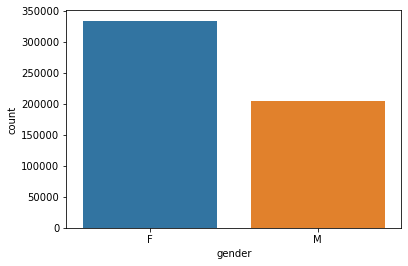

In [5]:
gender_plot = sns.countplot(x='gender',data=cca)


- fig(1): showcasing the gender distribution in the entire dataset (cca). The dataset cotains significantly more female than male users

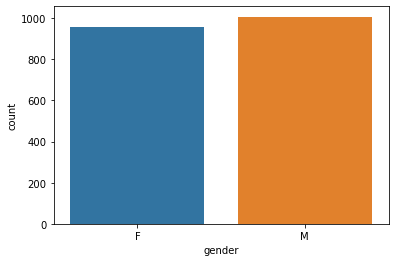

In [6]:
gender_plot_risk = sns.countplot(x='gender',data=risk)

- fig(2): showcasing the gender distribution in the dataset of all risk users (risk). The number of male risk users marginally surpases the number of female risk users.

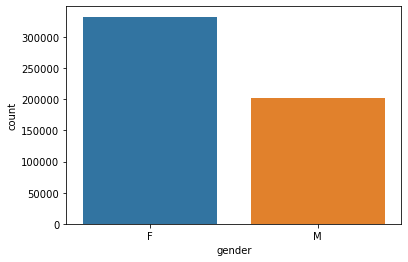

In [7]:
gender_plot_no_risk = sns.countplot(x='gender', data=not_risk)

- fig(3): showcasing the gender distribution in the dataset of all non-risk users (not_risk). The number of female non-risk users is significantly higher than the number of male non-risk users. 
- A male user has a higher chance of being a risk user in this sample.

## Pycaret and Model check
finding suitable models

In [127]:
stp = pycaret.classification.setup(data = cca, target = 'risk_user', train_size = 0.8,
            categorical_features = ['gender','owning_car','children_amt', 'owning_property', 'education_level',
                                    'marital_status', 'way_of_living','owning_work_phone', 
                                    'owning_phone','owning_email','job', 'payment_status'], 
            ignore_features = ['applicant_ID'], fix_imbalance = True)

,Description,Value
0,Session id,7564
1,Target,risk_user
2,Target type,Binary
3,Target mapping,"N: 0, Y: 1"
4,Original data shape,"(537667, 16)"
5,Transformed data shape,"(964660, 26)"
6,Transformed train set shape,"(857126, 26)"
7,Transformed test set shape,"(107534, 26)"
8,Ignore features,1
9,Ordinal features,6


In [128]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.4870
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.7350
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,38.8950
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.8770
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,63.0940
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,35.5120
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,26.9840
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,14.6890
knn,K Neighbors Classifier,0.9997,0.9729,0.9389,0.9762,0.9571,0.9569,0.9571,199.2070
qda,Quadratic Discriminant Analysis,0.9963,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.1430


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [141]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=7564, splitter='best')